<center>

# FraudHunter

### <i> Progetto per l'esame di Programmazione di applicazioni Data Intensive (2025) </i>

### Alessandro Valmori
#### Matricola: 0001089308
#### alessandro.valmori2@studio.unibo.it
</center>

## 1. Introduzione e Obiettivo del Progetto

Questo progetto si concentra sull'analisi di un dataset di transazioni con carte di credito al fine di addestrare e validare modelli di classificazione capaci di identificare transazioni fraudolente. Le frodi con carta di credito rappresentano un problema significativo per le istituzioni finanziarie e i consumatori, rendendo cruciale lo sviluppo di sistemi di rilevamento efficaci.

L'obiettivo principale è esplorare il dataset, preparare i dati per il machine learning, addestrare almeno due (preferibilmente tre o più) modelli di classificazione, valutarne le performance con metriche appropriate (data la natura sbilanciata del problema) e ottimizzare gli iperparametri di almeno un modello.

## 2. Setup dell'Ambiente e Caricamento Librerie

In questa sezione, importiamo tutte le librerie Python necessarie per l'analisi dei dati, la visualizzazione, il preprocessing, la modellazione e la valutazione.

In [1]:

import os
import json

import kagglehub
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint
import xgboost as xgb

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    GridSearchCV 
)
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler,
    PolynomialFeatures 
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline as ImbPipeline

from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Descrizione e Caricamento del Dataset

Utilizziamo il dataset "Credit Card Fraud Detection" da Kaggle. Questo dataset contiene transazioni effettuate con carte di credito europee nel settembre 2013. Presenta 284.807 transazioni, di cui solo 492 sono fraudolente (circa lo 0.172%).
Le feature `V1` a `V28` sono il risultato di una trasformazione PCA applicata ai dati originali per ragioni di confidenzialità. Le uniche feature non trasformate da PCA sono `Time` (secondi trascorsi tra ogni transazione e la prima transazione nel dataset) e `Amount` (l'importo della transazione). La variabile target è `Class`, che vale 1 in caso di frode e 0 altrimenti.

Procediamo con il caricamento e una prima ispezione del dataset.

In [2]:
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
data_subdir_name = "data"
target_data_dir = os.path.join(current_dir, data_subdir_name)
print(f"Target directory for dataset: {target_data_dir}")

os.makedirs(target_data_dir, exist_ok=True) 

dataset_slug = "mlg-ulb/creditcardfraud"
print(f"\nDownloading dataset '{dataset_slug}' with KaggleHub...")
try:
    dataset_path_in_cache = kagglehub.dataset_download(dataset_slug)
    print(f"Dataset downloaded to KaggleHub cache: {dataset_path_in_cache}")
    expected_file_name = "creditcard.csv"
    source_file_path = os.path.join(dataset_path_in_cache, expected_file_name)
    destination_file_path = os.path.join(target_data_dir, expected_file_name)

    if os.path.exists(source_file_path):
        print(f"\nFound dataset file in cache at: {source_file_path}")
        print(f"Copying '{source_file_path}' to '{destination_file_path}'...")
        shutil.copy2(source_file_path, destination_file_path) 
        
        if os.path.exists(destination_file_path):
            print(f"Successfully copied '{expected_file_name}' to '{target_data_dir}'.")
            print(f"File is now available at: {destination_file_path}")
        else:
            print(f"Error: File copying failed. '{destination_file_path}' not found after copy attempt.")
            
    else:
        print(f"\nError: File '{expected_file_name}' not found in the KaggleHub cache directory: {dataset_path_in_cache}.")
        if os.path.exists(dataset_path_in_cache) and os.path.isdir(dataset_path_in_cache):
            print(f"Files available in cache directory are: {os.listdir(dataset_path_in_cache)}")
        else:
            print(f"The cache path '{dataset_path_in_cache}' does not seem to be a valid directory.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

Current working directory: /home/siralex/Desktop/CREDIT_CARD/notebooks
Target directory for dataset: /home/siralex/Desktop/CREDIT_CARD/notebooks/data

Dataset downloaded to KaggleHub cache: /home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3

Found dataset file in cache at: /home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv
Copying '/home/siralex/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv' to '/home/siralex/Desktop/CREDIT_CARD/notebooks/data/creditcard.csv'...
Successfully copied 'creditcard.csv' to '/home/siralex/Desktop/CREDIT_CARD/notebooks/data'.
File is now available at: /home/siralex/Desktop/CREDIT_CARD/notebooks/data/creditcard.csv


## 4. Analisi Esplorativa dei Dati (EDA)

L'Analisi Esplorativa dei Dati (EDA) è fondamentale per comprendere la struttura del dataset, le distribuzioni delle variabili, le correlazioni e identificare eventuali problemi o pattern interessanti.

### 4.1. Analisi della Variabile Target (`Class`)
Iniziamo analizzando la distribuzione della variabile target per quantificare lo sbilanciamento.

In [3]:
try:
    df = pd.read_csv('data/creditcard.csv')
    pd.options.display.max_colwidth = 500
    print("Dataset caricato con successo.")
    print(f"Dimensioni del dataset: {df.shape}")
except FileNotFoundError:
    print("Errore: creditcard.csv non trovato. Assicurati che il file sia nella directory corretta.")
df.head()

Dataset caricato con successo.
Dimensioni del dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Come osservato, il dataset è estremamente sbilanciato: solo lo 0.17% delle transazioni sono etichettate come fraudolente. Questo sbilanciamento è una caratteristica cruciale che influenzerà la scelta delle metriche di valutazione e delle tecniche di modellazione (ad esempio, la necessità di tecniche di ricampionamento come SMOTE o l'uso di pesi di classe).

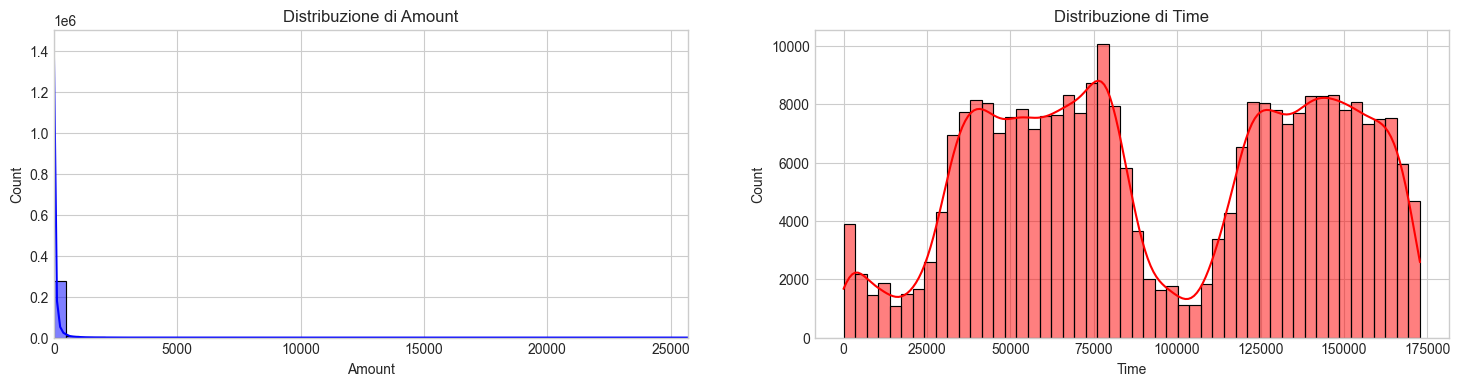

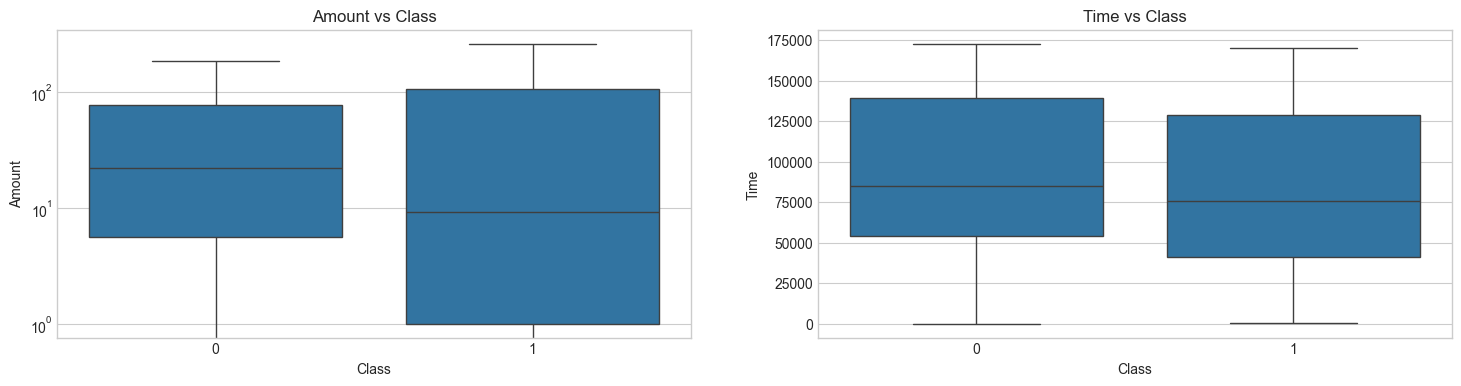

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuzione di Amount')
ax[0].set_xlim([min(df['Amount']), max(df['Amount'])])

sns.histplot(df['Time'], ax=ax[1], color='r', bins=50, kde=True)
ax[1].set_title('Distribuzione di Time')
plt.show()

fig2, ax2 = plt.subplots(1, 2, figsize=(18, 4))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False, ax=ax2[0])
ax2[0].set_title('Amount vs Class')
ax2[0].set_yscale('log')

sns.boxplot(x='Class', y='Time', data=df, ax=ax2[1])
ax2[1].set_title('Time vs Class')
plt.show()

**Osservazioni su `Time` e `Amount`:**

Dall'analisi grafica delle distribuzioni delle feature `Time` e `Amount`, possiamo trarre le seguenti considerazioni:

-   **Amount:**
    -   L'istogramma della feature `Amount` mostra una distribuzione fortemente asimmetrica a destra (right-skewed). Ciò indica che la maggior parte delle transazioni ha un importo relativamente piccolo, mentre un numero limitato di transazioni ha importi molto elevati (outlier).
    -   Il boxplot che confronta `Amount` per le transazioni fraudolente (`Class=1`) e quelle legittime (`Class=0`), specialmente quando visualizzato con una scala logaritmica sull'asse y per una migliore leggibilità, suggerisce che, sebbene ci sia una notevole sovrapposizione, la distribuzione degli importi per le transazioni fraudolente potrebbe avere caratteristiche leggermente diverse (ad esempio, una diversa mediana o range interquartile) rispetto a quelle legittime. Nonostante ciò, gli importi da soli non sembrano essere un discriminante forte. La rimozione degli outlier grafici (`showfliers=False`) aiuta a concentrarsi sul corpo principale delle distribuzioni.

-   **Time:**
    -   La feature `Time` rappresenta i secondi trascorsi tra ciascuna transazione e la prima transazione registrata nel dataset.
    -   L'istogramma di `Time` mostra un pattern bimodale. Questo andamento potrebbe riflettere cicli di attività giornalieri, come ad esempio una diminuzione del numero di transazioni durante le ore notturne e picchi durante le ore diurne/serali.
    -   Il boxplot che confronta `Time` per le due classi non rivela, a una prima analisi, pattern immediatamente evidenti.

Per catturare meglio i pattern ciclici giornalieri, trasformeremo la feature `Time` in due nuove feature: `sin_time_day` e `cos_time_day`. Queste rappresenteranno l'ora del giorno in modo ciclico, il che potrebbe essere più informativo per i modelli rispetto al semplice conteggio dei secondi. Queste nuove feature, essendo già in un range definito (-1 a 1), non necessiteranno di un ulteriore scaling separato come `Amount`, ma verranno processate insieme alle altre feature PCA.

In [8]:
seconds_in_day = 24 * 60 * 60
df['time_day_sec'] = df['Time'] % seconds_in_day # Time of day in seconds
df['sin_time_day'] = np.sin(2 * np.pi * df['time_day_sec'] / seconds_in_day)
df['cos_time_day'] = np.cos(2 * np.pi * df['time_day_sec'] / seconds_in_day)

df.drop(['Time', 'time_day_sec'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,sin_time_day,cos_time_day
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,1.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,1.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000073,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000073,1.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000145,1.0


### 4.3. Analisi delle Correlazioni
Esaminiamo la correlazione tra le features e la variabile target. Poiché le features `V1-V28` sono componenti PCA, ci aspettiamo che siano largamente incorrelate tra loro. La correlazione con la classe target può invece darci indicazioni sulle features potenzialmente più informative.

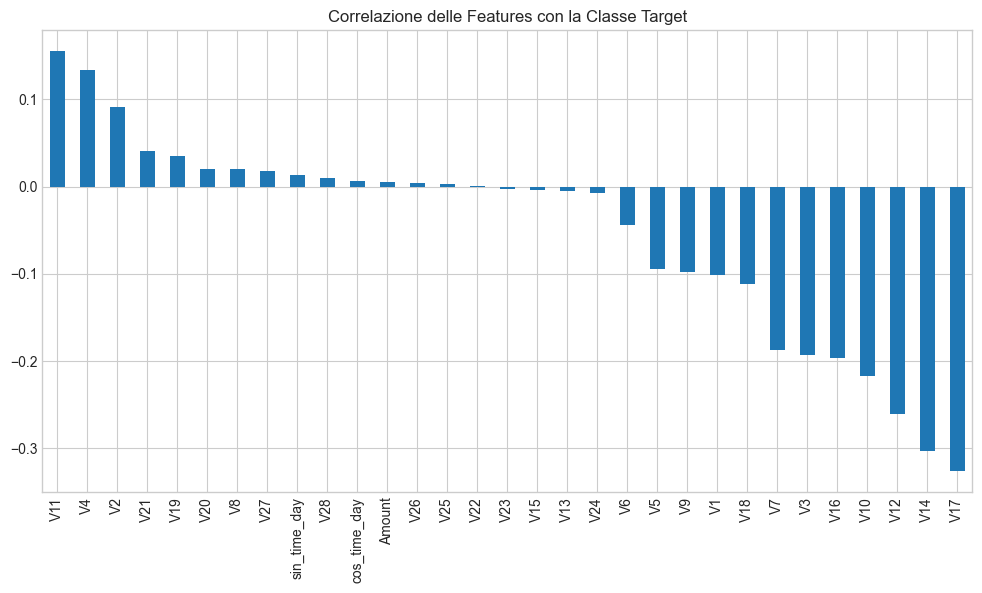

In [9]:
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
correlation_with_target.drop('Class').plot(kind='bar')
plt.title('Correlazione delle Features con la Classe Target')
plt.show()

**Osservazioni sulle Correlazioni:**

Il grafico a barre visualizza le correlazioni di Pearson tra ciascuna feature e la variabile target `Class`. Queste correlazioni ci forniscono una prima indicazione quantitativa della relazione lineare tra le singole feature e la probabilità che una transazione sia fraudolenta.

-   **Correlazioni Negative Marcate:**
    Alcune features PCA, in particolare `V17`, `V14`, `V12`, e `V10`, mostrano una correlazione negativa relativamente più marcata con la classe `Class`. Questo suggerisce che valori più bassi (o più negativi, data la natura delle componenti PCA) di queste features sono associati a una maggiore probabilità che la transazione sia una frode. Ad esempio, `V17` ha la correlazione negativa più forte.

-   **Correlazioni Positive Marcate:**
    Altre features PCA, come `V11`, `V4`, e `V2`, mostrano una correlazione positiva con la classe `Class`. Questo indica che valori più alti di queste features potrebbero essere associati a una maggiore probabilità di frode. `V11` spicca con la correlazione positiva più forte.

**Implicazioni:**
Le features con correlazioni (positive o negative) di magnitudine maggiore sono candidati promettenti per essere informative nei modelli di classificazione. Tuttavia, è importante ricordare che:
1.  La correlazione di Pearson misura solo relazioni lineari.
2.  Le features PCA sono combinazioni lineari delle feature originali (sconosciute) e, sebbene siano ortogonali tra loro, la loro correlazione individuale con il target non racconta l'intera storia. Interazioni tra feature potrebbero essere cruciali.
3.  Modelli più complessi (come Random Forest e XGBoost) sono in grado di catturare relazioni non lineari e interazioni che questa semplice analisi di correlazione potrebbe non evidenziare.

### 4.4. Distribuzione di Alcune Features PCA per Classe
Visualizziamo le distribuzioni di densità (KDE) per alcune delle features PCA che hanno mostrato una correlazione più significativa con la classe target, separando le transazioni legittime da quelle fraudolente. Questo può aiutarci a capire se ci sono differenze visibili nelle distribuzioni.

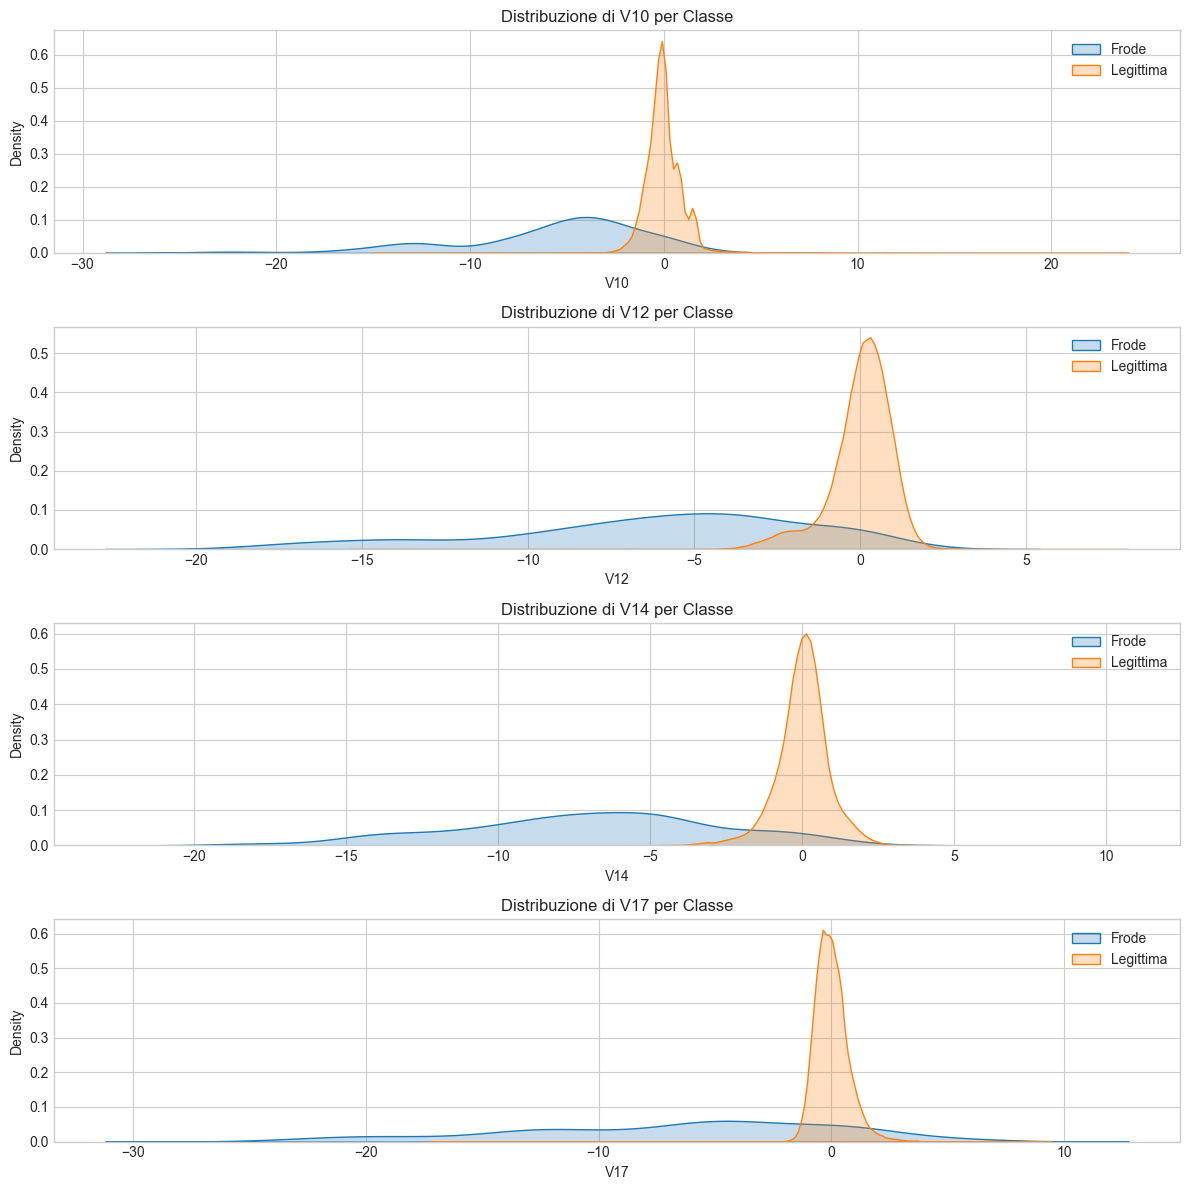

In [10]:
var_to_plot = ['V10', 'V12', 'V14', 'V17']
plt.figure(figsize=(12, len(var_to_plot)*3))
for i, var in enumerate(var_to_plot):
    plt.subplot(len(var_to_plot), 1, i+1)
    sns.kdeplot(df[var][df.Class == 1], label="Frode", fill=True)
    sns.kdeplot(df[var][df.Class == 0], label="Legittima", fill=True)
    plt.title(f'Distribuzione di {var} per Classe')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati per il Machine Learning

Per preparare i dati al machine learning, un passaggio cruciale è suddividerli in due insiemi distinti: uno per l'addestramento del modello e l'altro per la sua valutazione. Questa separazione è fondamentale perché ci permette di testare le prestazioni del modello su dati che non ha mai incontrato durante la fase di apprendimento, offrendo così una stima realistica di come si comporterà in scenari reali.

Nel nostro caso, abbiamo utilizzato la funzione train_test_split della libreria sklearn.model_selection, destinando l'80% dei dati all'addestramento e il restante 20% al test. Una considerazione particolarmente importante è stata la natura sbilanciata della nostra variabile target. Per far fronte a questo, abbiamo impostato il parametro stratify=y_original. In pratica, la stratificazione garantisce che la proporzione tra transazioni fraudolente e legittime sia la stessa sia nel training set sia nel test set, rispecchiando fedelmente la distribuzione originale delle classi. Questo assicura che entrambi gli insiemi di dati siano rappresentativi e che il modello venga addestrato e valutato in condizioni appropriate.

In [11]:
X_original = df.drop('Class', axis=1)
y_original = df['Class']

# Split dei dati
X_train, X_test, y_train, y_test = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)


Dato che la feature `Amount` ha una scala e distribuzione molto diversa rispetto alle feature PCA (`V1-V28`) e presenta outlier significativi usiamo uno scaler, poiché modelli sensibili alla scala delle feature beneficiano dello scaling.
Utilizziamo `RobustScaler` da `sklearn.preprocessing` per `Amount`, data la sua robustezza agli outlier, fittandolo **solo** sul training set e poi per trasformare sia `Amount` nel training set che nel test set.

In [12]:
# Scaling della colonna Amount
scaler_amount = RobustScaler()
X_train['scaled_amount'] = scaler_amount.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['scaled_amount'] = scaler_amount.transform(X_test['Amount'].values.reshape(-1, 1))

# Rimozione della colonna Amount originale
X_train.drop(['Amount'], axis=1, inplace=True)
X_test.drop(['Amount'], axis=1, inplace=True)

Salviamo lo scaler fittato

In [13]:
joblib.dump(scaler_amount, 'scaler_amount.joblib')
print("Scaler per Amount salvato in: scaler_amount.joblib")

Scaler per Amount salvato in: scaler_amount.joblib


## 6. Addestramento e Validazione dei Modelli di Classificazione

In questa sezione, si addestrano e si valutano tre diversi modelli di classificazione:

1.  **Regressione Logistica con regolarizzazione L1 (LASSO)**: Un modello lineare di base, ma con regolarizzazione L1 che può aiutare nella feature selection e prevenire l'overfitting. Verrà esplorata anche in combinazione con feature polinomiali per catturare possibili non linearità.
2.  **Random Forest Classifier**: Un modello basato su ensemble di alberi decisionali, generalmente robusto e capace di catturare interazioni complesse.
3.  **XGBoost Classifier**: Un'implementazione ottimizzata e potente di gradient boosting, spesso tra i modelli più performanti in molteplici task di classificazione.

Per la valutazione, data la natura sbilanciata del dataset, ci concentreremo su metriche come:

* **Precision (per la classe frode)**: Di tutte le transazioni predette come frode, quante lo sono realmente? (TP / (TP + FP))
* **Recall (per la classe frode)**: Di tutte le transazioni fraudolente reali, quante sono state identificate correttamente? (TP / (TP + FN)) - Questa è spesso la metrica più importante in questo contesto, poiché mancare una frode (Falso Negativo) è solitamente più costoso di un falso allarme (Falso Positivo).
* **F1-Score (per la classe frode)**: La media armonica di Precision e Recall, utile per bilanciare le due.
* **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: Misura la capacità del modello di distinguere tra le classi attraverso varie soglie.
* **AUC-PR (Area Under the Precision-Recall Curve)**: Particolarmente informativa per dataset sbilanciati, rappresenta la media delle precision a diversi valori di soglia.
* **Confusion Matrix**: Per visualizzare il numero di Veri Positivi (TP), Falsi Positivi (FP), Veri Negativi (TN) e Falsi Negativi (FN).

Per standardizzare e facilitare queste valutazioni, definiamo prima alcune funzioni ausiliarie che verranno riutilizzate per ciascun modello. Queste funzioni sono state progettate per:
* **Valutare in modo completo le performance**: Una funzione principale (`evaluate_model`) calcolerà l'accuratezza, la precisione, il recall e l'F1-score (specificamente per la classe frode), l'AUC-ROC e l'AUC-PR. Includerà anche la visualizzazione della matrice di confusione e la stampa del classification report.
* **Stimare l'incertezza delle metriche**: Verranno calcolati intervalli di confidenza per le principali metriche. Per l'accuratezza, si utilizzerà un intervallo basato sull'approssimazione normale (intervallo di Wilson con correzione di continuità, `calculate_confidence_interval`). Per precisione, recall e F1-score relativi alla classe frode, si implementerà un approccio basato su bootstrapping (`calculate_bootstrap_metric_ci`) per ottenere stime più robuste, data la potenziale scarsità di campioni della classe minoritaria.
* **Visualizzare la curva Precision-Recall**: Una funzione (`plot_precision_recall_curve`) dedicata permetterà di tracciare questa curva, offrendo una visione chiara del trade-off tra precisione e recall al variare della soglia di classificazione.
* **Ottimizzare e salvare la soglia di classificazione**: Una funzione (`find_and_save_optimal_f1_threshold`) identificherà la soglia di decisione che massimizza l'F1-score per la classe frode, una strategia utile per bilanciare precisione e recall. Tale soglia verrà poi salvata per un utilizzo futuro.

In [ ]:

from scipy.stats import norm # Per calcolare il valore Z

model_prefixes = ["LR", "RF", "XGB", "RF-OPT"]
prefix_to_model_key_map = {
    "LR": "LogReg",
    "RF": "RandomForest",  
    "RF-OPT": "RandomForest + GridSearchCV",
    "XGB": "XGBoost"
}

def calculate_bootstrap_metric_ci(y_true, y_pred, metric_func, 
                                  n_iterations=1000, confidence_level=0.95, 
                                  pos_label=1, zero_division_behavior=0):
    n_size = len(y_true)
    if n_size == 0:
        return (np.nan, np.nan)
        
    metric_scores = []
    y_true_np = np.array(y_true) 
    y_pred_np = np.array(y_pred)

    for _ in range(n_iterations):
        # Create bootstrap sample of indices
        indices = np.random.choice(np.arange(n_size), size=n_size, replace=True)
        
        # Get true and predicted labels for the current bootstrap sample
        y_true_sample = y_true_np[indices]
        y_pred_sample = y_pred_np[indices]
        
        score = np.nan 
        try:
            # For metrics that require pos_label and zero_division
            if metric_func in [precision_score, recall_score, f1_score]:
                score = metric_func(y_true_sample, y_pred_sample, 
                                    pos_label=pos_label, zero_division=zero_division_behavior)
            else: # For other metrics 
                score = metric_func(y_true_sample, y_pred_sample)
        except ValueError: 
            pass
            
        if not np.isnan(score): # Only append valid scores
             metric_scores.append(score)
    
    if not metric_scores: # If all bootstrap samples resulted in errors/NaNs
        print(f"Warning: Could not compute any valid scores for {metric_func.__name__} during bootstrapping.")
        return (np.nan, np.nan)

    alpha = 1.0 - confidence_level
    p_lower = (alpha / 2.0) * 100
    p_upper = (1 - (alpha / 2.0)) * 100
    
    return (np.percentile(metric_scores, p_lower), np.percentile(metric_scores, p_upper))


def calculate_confidence_interval(accuracy, n_samples, confidence_level=0.95):

    if n_samples == 0:
        return (np.nan, np.nan)
    if n_samples <= 30: 
        print(f"Attenzione: N={n_samples} potrebbe essere piccolo per l'approssimazione normale usata per l'IC.")

    # Calcola Z per il livello di confidenza specificato (due code)
    alpha = 1 - confidence_level
    z = norm.ppf(1 - alpha / 2)

    f = accuracy
    N = n_samples

    term_z_sq_over_2N = (z**2) / (2 * N)
    discriminant_term_numerator = (f * (1 - f) / N) + (z**2 / (4 * N**2)) 

    if discriminant_term_numerator < 0:
        print(f"Attenzione: Discriminante negativo ({discriminant_term_numerator:.4f}) nel calcolo dell'IC. N={N}, f={f:.4f}. L'approssimazione potrebbe non essere valida.")
        return (np.nan, np.nan)

    sqrt_discriminant = np.sqrt(discriminant_term_numerator)
    denominator = 1 + (z**2 / N)

    p_lower = (f + term_z_sq_over_2N - z * sqrt_discriminant) / denominator
    p_upper = (f + term_z_sq_over_2N + z * sqrt_discriminant) / denominator
    
    p_lower = max(0, p_lower)
    p_upper = min(1, p_upper)

    return (p_lower, p_upper)


def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modello", 
                   n_test_samples=None, confidence_level=0.95, 
                   bootstrap_iterations=1000, calculate_extra_cis=True):
    print(f"--- Valutazione: {model_name} ---")
    current_accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {current_accuracy:.4f}")
    
    roc_auc_val = None 
    avg_pr_val = None  
    y_scores_for_metrics = None

    # Confidence Interval for Accuracy 
    if n_test_samples is not None and n_test_samples > 0:
        acc_lower, acc_upper = calculate_confidence_interval(current_accuracy, n_test_samples, confidence_level)
        if not (np.isnan(acc_lower) or np.isnan(acc_upper)):
             print(f"  Intervallo di Confidenza ({confidence_level*100:.0f}%) per Accuracy: [{acc_lower:.4f} - {acc_upper:.4f}]")
        else:
            print(f"  Impossibile calcolare l'intervallo di confidenza per l'accuratezza con N={n_test_samples}.")
    else:
        print("  Numero di campioni di test non fornito o non valido per l'IC dell'accuracy.")
    
    # Point estimates for Precision, Recall, F1 for Fraud (pos_label=1)
    precision_fraud_point = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall_fraud_point = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_fraud_point = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    print(f"Precision (Fraud): {precision_fraud_point:.4f}")
    print(f"Recall (Fraud):    {recall_fraud_point:.4f}") 
    print(f"F1-Score (Fraud):  {f1_fraud_point:.4f}")  

    # Initialize CIs for returning
    ci_precision_fraud = (np.nan, np.nan)
    ci_recall_fraud = (np.nan, np.nan)
    ci_f1_fraud = (np.nan, np.nan)

    # Bootstrap CIs for Precision, Recall, F1 (Fraud)
    if calculate_extra_cis and len(y_true) > 0: # len(y_true) is n_test_samples for bootstrap
        print(f"  Calculating Bootstrap CIs ({bootstrap_iterations} iterations, {confidence_level*100:.0f}% CI) for P, R, F1 (Fraud)...")
        
        # Convert y_true to numpy array if it's a pandas Series, for bootstrap helper
        y_true_for_bootstrap = y_true.values if isinstance(y_true, pd.Series) else np.array(y_true)
        y_pred_for_bootstrap = np.array(y_pred)

        ci_precision_fraud = calculate_bootstrap_metric_ci(y_true_for_bootstrap, y_pred_for_bootstrap, precision_score, 
                                                           n_iterations=bootstrap_iterations, confidence_level=confidence_level, 
                                                           pos_label=1, zero_division_behavior=0)
        ci_recall_fraud = calculate_bootstrap_metric_ci(y_true_for_bootstrap, y_pred_for_bootstrap, recall_score, 
                                                        n_iterations=bootstrap_iterations, confidence_level=confidence_level, 
                                                        pos_label=1, zero_division_behavior=0)
        ci_f1_fraud = calculate_bootstrap_metric_ci(y_true_for_bootstrap, y_pred_for_bootstrap, f1_score, 
                                                    n_iterations=bootstrap_iterations, confidence_level=confidence_level, 
                                                    pos_label=1, zero_division_behavior=0)
        
        if not np.isnan(ci_precision_fraud[0]):
            print(f"    Bootstrap CI Precision (Fraud): [{ci_precision_fraud[0]:.4f} - {ci_precision_fraud[1]:.4f}]")
        if not np.isnan(ci_recall_fraud[0]):
            print(f"    Bootstrap CI Recall (Fraud):    [{ci_recall_fraud[0]:.4f} - {ci_recall_fraud[1]:.4f}]")
        if not np.isnan(ci_f1_fraud[0]):
            print(f"    Bootstrap CI F1-Score (Fraud):  [{ci_f1_fraud[0]:.4f} - {ci_f1_fraud[1]:.4f}]")
    
    if y_pred_proba is not None:
        if y_pred_proba.ndim == 2:
            y_scores_for_metrics = y_pred_proba[:, 1]
        else:
            y_scores_for_metrics = y_pred_proba 

        roc_auc_val = roc_auc_score(y_true, y_scores_for_metrics)
        avg_pr_val = average_precision_score(y_true, y_scores_for_metrics, pos_label=1)
        print(f"ROC AUC Score: {roc_auc_val:.4f}")
        print(f"Average Precision (AUC-PR): {avg_pr_val:.4f}") 
        
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legittima (0)', 'Frode (1)'], zero_division=0))
    print("--------------------------------------\n")

    return {
        'model': model_name,
        'accuracy': current_accuracy,
        'acc_ci_lower': acc_lower if 'acc_lower' in locals() else np.nan,
        'acc_ci_upper': acc_upper if 'acc_upper' in locals() else np.nan,
        'precision_fraud': precision_fraud_point,
        'precision_fraud_ci_lower': ci_precision_fraud[0],
        'precision_fraud_ci_upper': ci_precision_fraud[1],
        'recall_fraud': recall_fraud_point,
        'recall_fraud_ci_lower': ci_recall_fraud[0],
        'recall_fraud_ci_upper': ci_recall_fraud[1],
        'f1_fraud': f1_fraud_point,
        'f1_fraud_ci_lower': ci_f1_fraud[0],
        'f1_fraud_ci_upper': ci_f1_fraud[1],
        'roc_auc': roc_auc_val,
        'auc_pr': avg_pr_val
    }

model_results = []

In [15]:

def plot_precision_recall_curve(y_true, y_pred_proba_positive_class, model_name_for_plot, save_filename=None):

    precision_vals, recall_vals, _ = precision_recall_curve(
        y_true,
        y_pred_proba_positive_class,
        pos_label=1
    )
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(recall_vals, precision_vals, marker='.', markersize=5, linestyle='-', linewidth=1.5, label=model_name_for_plot)
    ax.set_xlabel('Recall (Frode)', fontsize=12)
    ax.set_ylabel('Precision (Frode)', fontsize=12)
    ax.set_title(f'Curva Precision-Recall\n{model_name_for_plot}', fontsize=14)
    ax.legend(fontsize=10, loc='lower left')
    ax.grid(True, linestyle=':', alpha=0.7)
    auc_pr_score_plot = average_precision_score(y_true, y_pred_proba_positive_class, pos_label=1)
    ax.text(0.6, 0.05, f'AUC-PR: {auc_pr_score_plot:.4f}', transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    plt.close(fig)


def find_and_save_optimal_f1_threshold(y_true, y_pred_proba_positive_class, model_name_prefix, model_description_for_print="Modello"):
    precision_vals, recall_vals, thresholds_prc = precision_recall_curve(
        y_true,
        y_pred_proba_positive_class,
        pos_label=1
    )

    optimal_threshold = None
    optimal_f1_value = 0.0
    corresponding_precision = 0.0
    corresponding_recall = 0.0

    if len(thresholds_prc) == 0:
        print(f"Attenzione: Nessuna soglia trovata da precision_recall_curve per {model_description_for_print}. Impossibile ottimizzare la soglia.")
        return optimal_threshold, optimal_f1_value, corresponding_precision, corresponding_recall

    precisions_for_thresholds = precision_vals[:-1]
    recalls_for_thresholds = recall_vals[:-1]

    denominator_f1 = precisions_for_thresholds + recalls_for_thresholds
    f1_scores = np.zeros_like(denominator_f1)
    valid_indices_f1 = denominator_f1 > 1e-9
    f1_scores[valid_indices_f1] = (2 * precisions_for_thresholds[valid_indices_f1] * recalls_for_thresholds[valid_indices_f1]) / \
                                  denominator_f1[valid_indices_f1]

    if len(f1_scores) > 0:
        idx_optimal = np.argmax(f1_scores)
        optimal_f1_value = f1_scores[idx_optimal]
        optimal_threshold = thresholds_prc[idx_optimal]
        corresponding_precision = precisions_for_thresholds[idx_optimal]
        corresponding_recall = recalls_for_thresholds[idx_optimal]

        print(f"\nSoglia per {model_description_for_print} (Max F1-Score): {optimal_threshold:.4f}")
        print(f"  Con questa soglia -> F1-Score: {optimal_f1_value:.4f}, Precision: {corresponding_precision:.4f}, Recall: {corresponding_recall:.4f}")

        threshold_to_save_content = {'thresh': float(optimal_threshold)} 
        threshold_output_filename = f"{model_name_prefix}_thresh.json"
        try:
            with open(threshold_output_filename, 'w') as f:
                json.dump(threshold_to_save_content, f, indent=4)
            print(f"Soglia ottimale per F1 ({model_description_for_print}: {float(optimal_threshold):.4f}) salvata in '{threshold_output_filename}'")
        except Exception as e:
            print(f"Errore durante il salvataggio della soglia in '{threshold_output_filename}': {e}")
    else:
        print(f"Attenzione: Non è stato possibile calcolare F1-scores validi per l'ottimizzazione di {model_description_for_print}.")
        return None, 0, 0, 0

    return optimal_threshold, optimal_f1_value, corresponding_precision, corresponding_recall

### 6.1. Regressione Logistica 

Caricamento iperparametri da 'best_LR_C.json'...
Iperparametri caricati: {'classifier__C': 0.003727593720314938}

--- Addestramento Pipeline Logistic Regression con Iperparametri Caricati ---
Pipeline addestrata con iperparametri caricati.

Feature selezionate (10): ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
--- Valutazione: LogReg Pipeline (k=10, C=0.0037) ---
Accuracy: 0.9760
  Intervallo di Confidenza (95%) per Accuracy: [0.9747 - 0.9772]
Precision (Fraud): 0.0621
Recall (Fraud):    0.9184
F1-Score (Fraud):  0.1163
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.0494 - 0.0756]
    Bootstrap CI Recall (Fraud):    [0.8681 - 0.9681]
    Bootstrap CI F1-Score (Fraud):  [0.0946 - 0.1388]
ROC AUC Score: 0.9762
Average Precision (AUC-PR): 0.7697

Confusion Matrix:


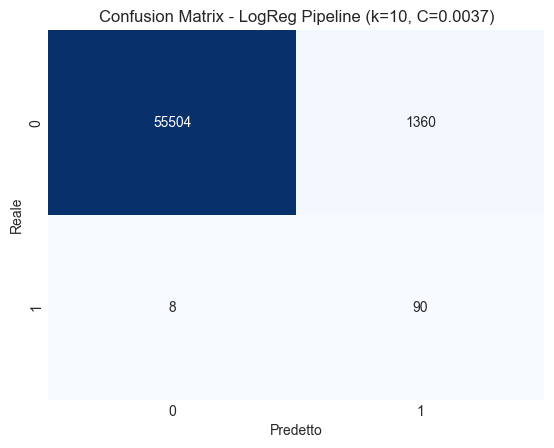


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      0.98      0.99     56864
    Frode (1)       0.06      0.92      0.12        98

     accuracy                           0.98     56962
    macro avg       0.53      0.95      0.55     56962
 weighted avg       1.00      0.98      0.99     56962

--------------------------------------

Pipeline Logistic Regression salvata.


In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

hyperparams_filename_lr = 'best_LR_C.json'
FORCE_NEW_SEARCH_LR = False
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_pipeline = ImbPipeline([
    ('feature_selection', SelectKBest(
        score_func=f_classif, 
        k=10  
    )),
    ('poly', PolynomialFeatures(
        degree=2, 
        include_bias=False, 
        interaction_only=False
    )),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=42,
        max_iter=1500,
        tol=0.001
    ))
])

if not FORCE_NEW_SEARCH_LR and os.path.exists(hyperparams_filename_lr):
    print(f"Caricamento iperparametri da '{hyperparams_filename_lr}'...")
    with open(hyperparams_filename_lr, 'r') as f:
        best_lr_params_loaded = json.load(f)
    print(f"Iperparametri caricati: {best_lr_params_loaded}")
    
    print(f"\n--- Addestramento Pipeline Logistic Regression con Iperparametri Caricati ---")
    lr_pipeline.set_params(**best_lr_params_loaded)
    lr_pipeline.fit(X_train, y_train)
    lr_pipeline_tuned = lr_pipeline
    print("Pipeline addestrata con iperparametri caricati.")
    
else:
    print(f"\nInizio Grid Search per Pipeline Logistic Regression...")
    
    # Definizione spazio parametri
    param_grid_lr = {
        'feature_selection__k': [8, 10, 12],  
        'classifier__C': np.logspace(-3, 1, 8)  # Parametro di regolarizzazione
    }
    
    # Grid Search
    grid_search_lr = GridSearchCV(
        estimator=lr_pipeline,
        param_grid=param_grid_lr,
        scoring='average_precision',
        cv=cv_stratified,
        verbose=1,
        n_jobs=-1
    )
    
    grid_search_lr.fit(X_train, y_train)
    best_lr_params_found = grid_search_lr.best_params_
    
    print(f"\nMigliori parametri trovati salvati in {best_lr_params_found}")
    try:
        with open(hyperparams_filename_lr, 'w') as f:
            json.dump(best_lr_params_found, f, indent=4)
        print(f"Migliori iperparametri salvati in '{hyperparams_filename_lr}'")
    except Exception as e:
        print(f"Errore durante il salvataggio: {e}")
    
    lr_pipeline_tuned = grid_search_lr.best_estimator_

# Predizioni
y_pred_lr = lr_pipeline_tuned.predict(X_test)
y_pred_proba_lr = lr_pipeline_tuned.predict_proba(X_test)

# Ottenimento parametri ottimali e feature selezionate
optimal_C = lr_pipeline_tuned.named_steps['classifier'].C
k_features = lr_pipeline_tuned.named_steps['feature_selection'].k
selected_features_mask = lr_pipeline_tuned.named_steps['feature_selection'].get_support()
selected_features_lr = X_train.columns[selected_features_mask].tolist()

print(f"\nFeature selezionate ({len(selected_features_lr)}): {selected_features_lr}")

# Valutazione
model_name_lr = f"LogReg Pipeline (k={k_features}, C={optimal_C:.4f})"
results_lr = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_lr,
    y_pred_proba=y_pred_proba_lr,
    model_name=model_name_lr,
    n_test_samples=len(y_test)
)
model_results.append(results_lr)

# Salvataggio
joblib.dump(ImbPipeline(lr_pipeline_tuned.steps[1:]), 'LR_model.joblib')
joblib.dump(selected_features_lr, 'LR_columns.joblib')
print("Pipeline Logistic Regression salvata.")

### Analisi della Soglia di Classificazione e Curva Precision-Recall per LASSO LogReg Polinomiale

Dopo aver addestrato il nostro modello LASSO LogReg Polinomiale ottimizzato con GridSearchCV (utilizzando 10 feature pre-selezionate e SMOTE nella pipeline), la valutazione iniziale è stata effettuata con la soglia di classificazione di default (0.5)

Come si può notare, con la soglia di default, il modello ha un **Recall molto alto (0.9184)** per le frodi, il che significa che identifica correttamente la maggior parte delle frodi reali. Tuttavia, la **Precision è estremamente bassa (0.0594)**, indicando un numero molto elevato di falsi positivi (transazioni legittime erroneamente segnalate come frode). Questo scenario, sebbene catturi molte frodi, potrebbe non essere pratico a causa dell'alto costo associato alla gestione dei falsi allarmi.

Per problemi con classi sbilanciate, la soglia di default raramente rappresenta il miglior compromesso. Nella cella seguente si calcola la soglia che massimizza l'**F1-Score** (media armonica di Precision e Recall).

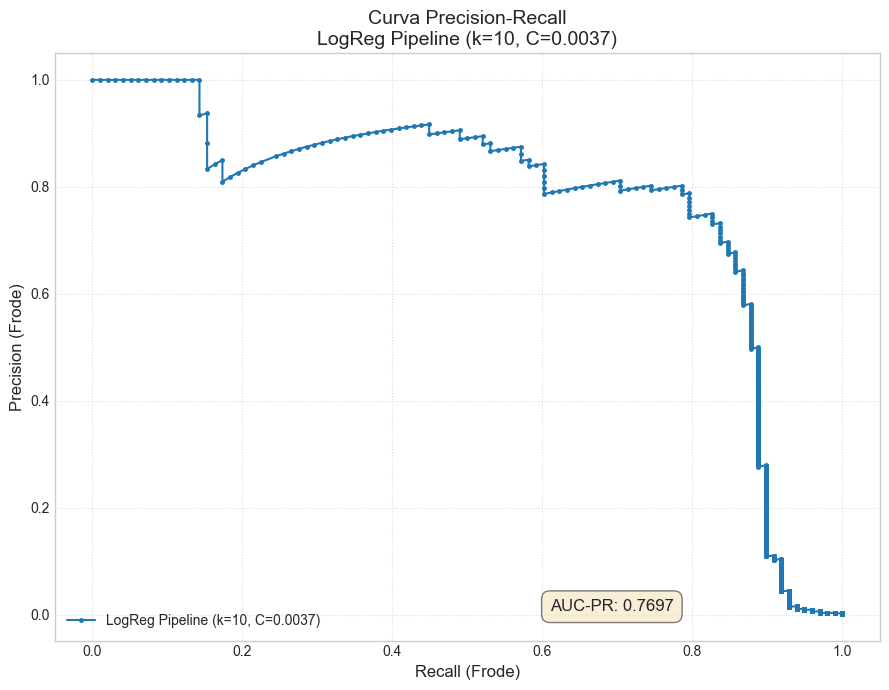


Ricerca soglia ottimale per LogReg Pipeline (k=10, C=0.0037) (massimizzando F1-Score)...

Soglia per LogReg Pipeline (k=10, C=0.0037) (Max F1-Score): 0.9990
  Con questa soglia -> F1-Score: 0.7938, Precision: 0.8021, Recall: 0.7857
Soglia ottimale per F1 (LogReg Pipeline (k=10, C=0.0037): 0.9990) salvata in 'LR_thresh.json'

--- Valutazione LogReg Pipeline (k=10, C=0.0037), ThMaxF1=0.9990 con Soglia Ottimizzata per Max F1 (0.9990) ---
--- Valutazione: LogReg Pipeline (k=10, C=0.0037), ThMaxF1=0.9990 ---
Accuracy: 0.9993
  Intervallo di Confidenza (95%) per Accuracy: [0.9990 - 0.9995]
Precision (Fraud): 0.8021
Recall (Fraud):    0.7857
F1-Score (Fraud):  0.7938
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.7200 - 0.8791]
    Bootstrap CI Recall (Fraud):    [0.7053 - 0.8617]
    Bootstrap CI F1-Score (Fraud):  [0.7284 - 0.8544]
ROC AUC Score: 0.9762
Average Precision (AUC-PR): 0.7697

Confusion Matrix:


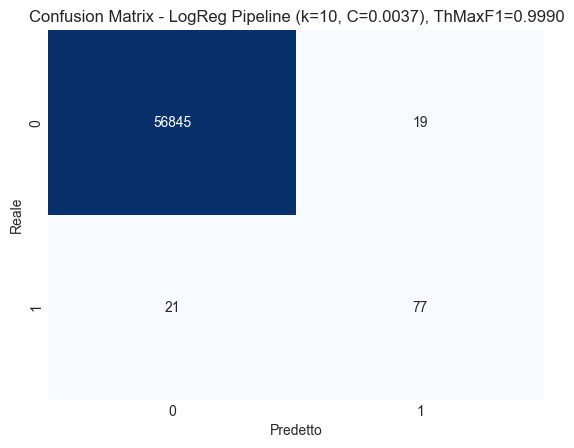


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.80      0.79      0.79        98

     accuracy                           1.00     56962
    macro avg       0.90      0.89      0.90     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Numero di feature (post-poly, post-scaling) con coeff. non nullo nel LogReg Pipeline (k=10, C=0.0037): 59
Prime 10 feature (post-poly, post-scaling) per valore assoluto del coeff. nel LogReg Pipeline (k=10, C=0.0037):
V4        1.755841
V14       0.950060
V12       0.779634
V18^2     0.736054
V10       0.585493
V7 V17    0.537986
V16       0.513056
V4 V7     0.507085
V4^2      0.506621
V3 V11    0.504764
dtype: float64


In [17]:
y_pred_proba_fraud_lr = y_pred_proba_lr[:, 1]

plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_lr,
    model_name_lr, 
)

print(f"\nRicerca soglia ottimale per {model_name_lr} (massimizzando F1-Score)...")
optimal_threshold_lr_f1, f1_val_lr, prec_lr_at_f1, rec_lr_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_lr,
    model_name_prefix="LR", 
    model_description_for_print=model_name_lr
)

y_pred_lr_optimized_f1_thresh = (y_pred_proba_fraud_lr >= optimal_threshold_lr_f1).astype(int)

model_name_lr_optimized_f1 = f"{model_name_lr}, ThMaxF1={optimal_threshold_lr_f1:.4f}"

print(f"\n--- Valutazione {model_name_lr_optimized_f1} con Soglia Ottimizzata per Max F1 ({optimal_threshold_lr_f1:.4f}) ---")
results_lr_optimized_f1 = evaluate_model(
    y_test,
    y_pred_lr_optimized_f1_thresh,
    y_pred_proba_lr, 
    model_name_lr_optimized_f1,
    n_test_samples=len(y_test),
)

model_results.append(results_lr_optimized_f1)

final_lr_classifier_step = lr_pipeline_tuned.named_steps['classifier']
final_poly_step = lr_pipeline_tuned.named_steps['poly']

poly_feature_names_final = final_poly_step.get_feature_names_out(selected_features_lr)
lr_coeffs = pd.Series(final_lr_classifier_step.coef_[0], index=poly_feature_names_final)
selected_lr_coeffs = lr_coeffs[lr_coeffs != 0]

print(f"\nNumero di feature (post-poly, post-scaling) con coeff. non nullo nel {model_name_lr}: {len(selected_lr_coeffs)}")
if len(selected_lr_coeffs) > 0:
    print(f"Prime 10 feature (post-poly, post-scaling) per valore assoluto del coeff. nel {model_name_lr}:")
    print(selected_lr_coeffs.abs().sort_values(ascending=False).head(10))
else:
    print(f"Nessuna feature selezionata da {model_name_lr} (tutti i coefficienti sono zero).")

In [18]:
pd.DataFrame(model_results)

,model,accuracy,acc_ci_lower,acc_ci_upper,precision_fraud,precision_fraud_ci_lower,precision_fraud_ci_upper,recall_fraud,recall_fraud_ci_lower,recall_fraud_ci_upper,f1_fraud,f1_fraud_ci_lower,f1_fraud_ci_upper,roc_auc,auc_pr
0,"LogReg Pipeline (k=10, C=0.0037)",0.975984,0.974694,0.977210,0.062069,0.049446,0.075576,0.918367,0.868095,0.968094,0.116279,0.094558,0.138763,0.976242,0.769683
1,"LogReg Pipeline (k=10, C=0.0037), ThMaxF1=0.9990",0.999298,0.999044,0.999484,0.802083,0.719969,0.879131,0.785714,0.705251,0.861711,0.793814,0.728447,0.854369,0.976242,0.769683


Rivalutando il modello con questa nuova soglia "ottimale", abbiamo ottenuto:

-   **Accuracy:** aumentata.
-   **Precision (Frode):** aumentata drasticamente.
-   **Recall (Frode):** diminuita, come atteso, ma ancora buona.
-   **F1-Score (Frode):** aumentato significativamente.

**Osservazioni sull'Impatto della Soglia:**
-   Alzando la soglia da ~0.5 a ~0.9990, la Precision per le frodi è migliorata enormemente, passando da circa 6% a oltre 80%. Questo significa che il numero di falsi positivi si è ridotto drasticamente.
-   Come previsto, il Recall è diminuito (da ~92% a ~79%), il che significa che abbiamo perso la capacità di identificare alcune frodi che prima venivano catturate.
-   Tuttavia, l'F1-Score è migliorato notevolmente, indicando un bilanciamento complessivamente migliore tra Precision e Recall con la nuova soglia.
-   L'AUC-ROC e l'AUC-PR rimangono invariati perché misurano la performance del modello su tutte le possibili soglie; il tuning della soglia seleziona solo un punto operativo su queste curve.

La scelta della soglia ottimale dipende dal contesto applicativo. Se il costo di un Falso Negativo (frode non rilevata) è estremamente alto, si potrebbe preferire una soglia più bassa per massimizzare il Recall, accettando più falsi positivi. Se, invece, il costo dei Falsi Positivi (indagare transazioni legittime) è predominante, una soglia più alta come quella trovata potrebbe essere preferibile. La massimizzazione dell'F1-score rappresenta un compromesso ragionevole.

### 6.2. XGBoost Classifier (con Feature Selection dedicata e SMOTE)

Successivamente, esploreremo le capacità di XGBoost (Extreme Gradient Boosting), un algoritmo di machine learning basato su gradient boosting che è noto per le sue elevate performance e la sua efficienza, specialmente in competizioni di data science e in problemi di classificazione complessi.

**Strategia Adottata per XGBoost:**

1.  **Feature Selection Preliminare con `SelectFromModel`**:
    * Dato che il dataset originale contiene molte feature, addestrare XGBoost su tutte le feature potrebbe essere computazionalmente intensivo e non necessariamente ottimale se alcune feature sono rumorose o poco informative.
    * Per questo motivo, eseguiremo una fase di feature selection. Addestreremo un modello XGBoost preliminare sull'intero training set. Per gestire lo sbilanciamento delle classi durante questa fase di stima dell'importanza delle feature, utilizzeremo il parametro `scale_pos_weight` di XGBoost, che assegna un peso maggiore alla classe minoritaria (frodi).
    * Le feature importances calcolate da questo modello preliminare verranno poi utilizzate con `sklearn.feature_selection.SelectFromModel`. Imposteremo `threshold="median"` per selezionare le feature la cui importanza è superiore o uguale alla mediana di tutte le importanze. Questo approccio mira a conservare un sottoinsieme robusto delle feature più predittive.

2.  **Applicazione di SMOTE sul Training Set Ridotto**:
    * Una volta ottenuto il sottoinsieme di feature selezionate, applicheremo SMOTE **solo** al training set (ridotto a queste feature). Questo passaggio, come per i modelli precedenti, ha lo scopo di bilanciare le classi prima dell'addestramento del modello XGBoost finale, permettendogli di apprendere meglio le caratteristiche delle frodi.

Addestramento pipeline XGBoost...


/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:50:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:50:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Feature selezionate XGBoost (16): ['V4', 'V7', 'V8', 'V12', 'V13', 'V14', 'V15', 'V17', 'V18', 'V19', 'V20', 'V22', 'V26', 'V27', 'V28', 'scaled_amount']
--- Valutazione: XGBoost ---
Accuracy: 0.9987
  Intervallo di Confidenza (95%) per Accuracy: [0.9983 - 0.9989]
Precision (Fraud): 0.5764
Recall (Fraud):    0.8469
F1-Score (Fraud):  0.6860
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.4910 - 0.6586]
    Bootstrap CI Recall (Fraud):    [0.7717 - 0.9136]
    Bootstrap CI F1-Score (Fraud):  [0.6244 - 0.7491]
ROC AUC Score: 0.9679
Average Precision (AUC-PR): 0.8481

Confusion Matrix:


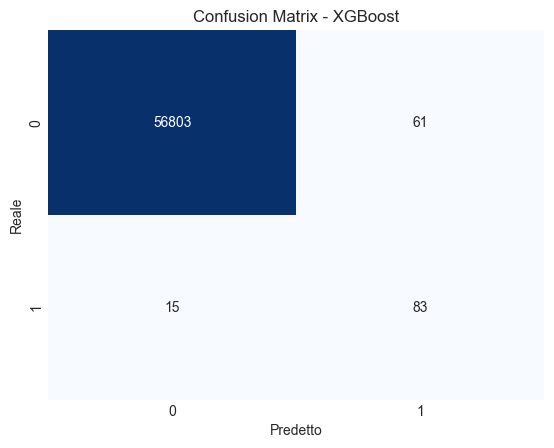


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.58      0.85      0.69        98

     accuracy                           1.00     56962
    macro avg       0.79      0.92      0.84     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Pipeline XGBoost salvata.


In [19]:
# Calcolo scale_pos_weight per gestire il bilanciamento delle classi
train_counts = y_train.value_counts()
scale_pos_weight = train_counts[0] / train_counts[1] if train_counts[1] > 0 else 1

# Definizione della pipeline completa XGBoost
xgb_pipeline = ImbPipeline([
    ('feature_selection', SelectFromModel(
        xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='aucpr',
            use_label_encoder=False,
            random_state=42,
            scale_pos_weight=scale_pos_weight
        ),
        threshold="median"
    )),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        use_label_encoder=False,
        random_state=42
    ))
])

# Addestramento della pipeline
print("Addestramento pipeline XGBoost...")
xgb_pipeline.fit(X_train, y_train)

# Predizioni
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)

# Ottenimento delle feature selezionate
selected_features_xgb = X_train.columns[xgb_pipeline.named_steps['feature_selection'].get_support()].tolist()
print(f"Feature selezionate XGBoost ({len(selected_features_xgb)}): {selected_features_xgb}")

# Valutazione
results_xgb = evaluate_model(
    y_test,
    y_pred_xgb,
    y_pred_proba_xgb,
    "XGBoost",
    n_test_samples=len(y_test)
)
model_results.append(results_xgb)

# Salvataggio
joblib.dump(ImbPipeline(xgb_pipeline.steps[1:]), 'XGB_model.joblib')
joblib.dump(selected_features_xgb, 'XGB_columns.joblib')
print("Pipeline XGBoost salvata.")

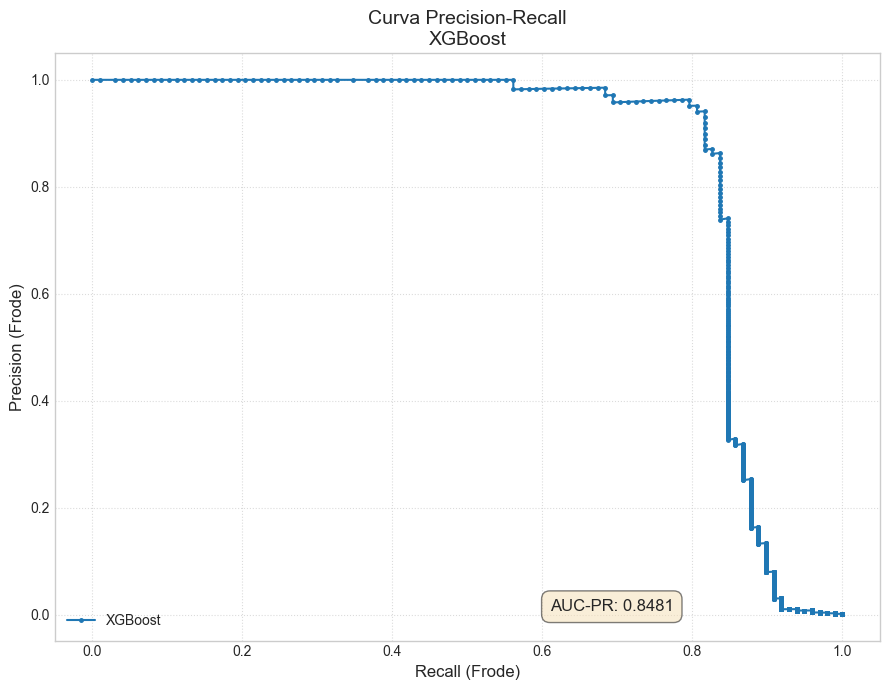


Soglia per XGBoost (Max F1-Score): 0.9797
  Con questa soglia -> F1-Score: 0.8743, Precision: 0.9412, Recall: 0.8163
Soglia ottimale per F1 (XGBoost: 0.9797) salvata in 'XGB_thresh.json'

--- Valutazione XGBoost con Soglia Ottimizzata per Max F1 (0.9797) ---
--- Valutazione: XGBoost, ThMaxF1={optimal_threshold_xgb_f1:.4f} ---
Accuracy: 0.9996
  Intervallo di Confidenza (95%) per Accuracy: [0.9994 - 0.9997]
Precision (Fraud): 0.9412
Recall (Fraud):    0.8163
F1-Score (Fraud):  0.8743
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.8861 - 0.9878]
    Bootstrap CI Recall (Fraud):    [0.7312 - 0.8868]
    Bootstrap CI F1-Score (Fraud):  [0.8197 - 0.9193]
ROC AUC Score: 0.9679
Average Precision (AUC-PR): 0.8481

Confusion Matrix:


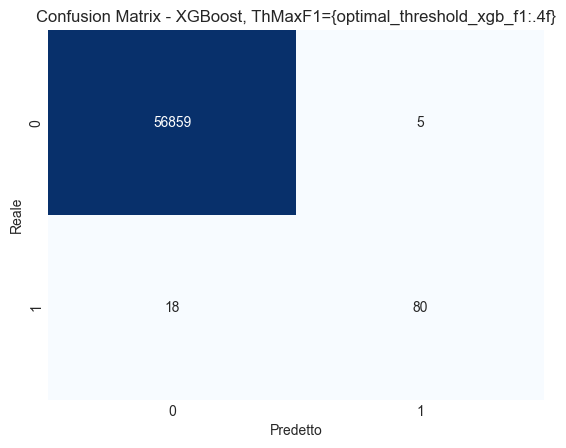


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.94      0.82      0.87        98

     accuracy                           1.00     56962
    macro avg       0.97      0.91      0.94     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Risultati per XGBoost, ThMaxF1=0.9797 aggiunti a model_results.


In [20]:
y_pred_proba_fraud_xgb = y_pred_proba_xgb[:, 1]
model_name_xgb_base_for_plot = f"XGBoost"

plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_xgb,
    model_name_xgb_base_for_plot,
)

optimal_threshold_xgb_f1, f1_val_xgb, prec_xgb_at_f1, rec_xgb_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_xgb,
    model_name_prefix="XGB", 
    model_description_for_print=model_name_xgb_base_for_plot
)
    
y_pred_xgb_optimized_f1_thresh = (y_pred_proba_fraud_xgb >= optimal_threshold_xgb_f1).astype(int)


print(f"\n--- Valutazione {model_name_xgb_base_for_plot} con Soglia Ottimizzata per Max F1 ({optimal_threshold_xgb_f1:.4f}) ---")
results_xgb_optimized_f1 = evaluate_model(
    y_test,
    y_pred_xgb_optimized_f1_thresh,
    y_pred_proba_xgb,
    "XGBoost, ThMaxF1={optimal_threshold_xgb_f1:.4f}",
    n_test_samples=len(y_test)
)

model_results.append(results_xgb_optimized_f1)

print(f"Risultati per XGBoost, ThMaxF1={optimal_threshold_xgb_f1:.4f} aggiunti a model_results.")



In [21]:
pd.DataFrame(model_results[2:4])

,model,accuracy,acc_ci_lower,acc_ci_upper,precision_fraud,precision_fraud_ci_lower,precision_fraud_ci_upper,recall_fraud,recall_fraud_ci_lower,recall_fraud_ci_upper,f1_fraud,f1_fraud_ci_lower,f1_fraud_ci_upper,roc_auc,auc_pr
0,XGBoost,0.998666,0.998331,0.998934,0.576389,0.490994,0.658570,0.846939,0.771699,0.913598,0.685950,0.624377,0.749139,0.967874,0.848132
1,"XGBoost, ThMaxF1={optimal_threshold_xgb_f1:.4f}",0.999596,0.999394,0.999731,0.941176,0.886055,0.987809,0.816327,0.731183,0.886817,0.874317,0.819662,0.919273,0.967874,0.848132


**Osservazioni sull'XGBoost Classifier (Base, con Feature Selection e SMOTE)**

L'XGBoost base con soglia di default dimostra una buona capacità di identificare una porzione significativa delle frodi reali (Recall elevato). Tuttavia, la Precision (0.5395), sebbene modesta, indica ancora che una parte considerevole delle transazioni segnalate come frode sono in realtà falsi positivi. L'AUC-PR di 0.8462 è un risultato promettente.

**Impatto dell'Ottimizzazione della Soglia (massimizzando F1-Score):**
Dall'analisi della curva Precision-Recall, è stata identificata una soglia ottimale di circa **0.9756** per massimizzare l'F1-Score. Con questa soglia, notiamo un notevole aumento della Precision e del F1-Score, corrisposta da un'attesa diminuzione della Recall.

Questo porta a un modello molto più bilanciato e con un numero inferiore di falsi positivi.

### 6.3. Random Forest Classifier
Per il Random Forest Classifier, abbiamo implementato una pipeline integrata che combina feature selection, bilanciamento dei dati e classificazione. La pipeline utilizza `SelectFromModel` con un Random Forest preliminare (`class_weight='balanced_subsample'`) e `threshold="median"` per selezionare automaticamente le feature più rilevanti. Successivamente, SMOTE viene applicato per bilanciare le classi, e infine un Random Forest finale viene addestrato sui dati processati. 

Feature selezionate (16): ['V2', 'V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'scaled_amount']
--- Valutazione: Random Forest ---
Accuracy: 0.9994
  Intervallo di Confidenza (95%) per Accuracy: [0.9991 - 0.9995]
Precision (Fraud): 0.8081
Recall (Fraud):    0.8163
F1-Score (Fraud):  0.8122
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.7333 - 0.8824]
    Bootstrap CI Recall (Fraud):    [0.7362 - 0.8948]
    Bootstrap CI F1-Score (Fraud):  [0.7475 - 0.8683]
ROC AUC Score: 0.9581
Average Precision (AUC-PR): 0.8690

Confusion Matrix:


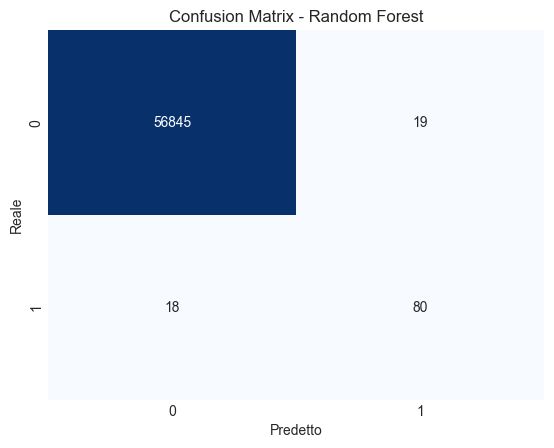


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.81      0.82      0.81        98

     accuracy                           1.00     56962
    macro avg       0.90      0.91      0.91     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest salvato.


In [ ]:
# Definizione della pipeline completa
rf_pipeline = ImbPipeline([
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1
        ),
        threshold="median"
    )),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])



rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)

selected_features = X_train.columns[rf_pipeline.named_steps['feature_selection'].get_support()].tolist()
print(f"Feature selezionate ({len(selected_features)}): {selected_features}")

results_rf = evaluate_model(
    y_test,
    y_pred_rf,
    y_pred_proba_rf,
    "Random Forest",
    n_test_samples=len(y_test)
)
model_results.append(results_rf)

# Salvataggio
joblib.dump(ImbPipeline(rf_pipeline.steps[1:]), 'RF_model.joblib')
joblib.dump(selected_features, 'RF_columns.joblib')
print("Modello Random Forest salvato.")

**Osservazioni su Random Forest Classifier (con Feature Selection dedicata tramite `SelectFromModel`)**

Per il Random Forest Classifier, abbiamo seguito un approccio simile a XGBoost per la feature selection, ma utilizzando un Random Forest preliminare per determinare l'importanza delle feature. Il **Recall (0.8163)** è alto, e la **Precision (0.8247)** è anch'essa elevata, indicando un buon equilibrio tra l'identificazione delle frodi e la minimizzazione dei falsi allarmi con la soglia di default.
    * L'**F1-Score (0.8205)** e l'**AUC-PR (0.8744)** sono i più alti finora tra i modelli base (confrontati con LASSO LogReg con soglia default e XGBoost con soglia default).
    * Questi risultati suggeriscono che Random Forest, anche con iperparametri di default ma con una buona strategia di feature selection e gestione dello sbilanciamento, è un candidato molto forte.

**Considerazioni**:
Le performance di questo modello Random Forest sono già notevoli, superando il LASSO LogReg (anche con soglia ottimizzata per F1-score in termini di AUC-PR e F1-score sul default) e l'XGBoost in termini di bilanciamento Precision/Recall per la classe frode. Questo lo rende un eccellente candidato per un'ulteriore ottimizzazione degli iperparametri.

## 7. Ottimizzazione degli Iperparametri con RandomizedSearchCV per Random Forest

Dopo aver osservato le promettenti performance del Random Forest Classifier procediamo con l'ottimizzazione dei suoi iperparametri. L'obiettivo è esplorare uno spazio di possibili configurazioni per trovare una combinazione che possa ulteriormente migliorare le sue capacità predittive.

Caricamento iperparametri per pipeline RF da 'best_rf_hyperparams.json'...
Iperparametri caricati: {'classifier__criterion': 'entropy', 'classifier__max_depth': 40, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 143}

--- Addestramento Pipeline Random Forest con Iperparametri Caricati ---
Pipeline Random Forest addestrata con iperparametri caricati.
--- Valutazione: RF-OPT ---
Accuracy: 0.9995
  Intervallo di Confidenza (95%) per Accuracy: [0.9992 - 0.9996]
Precision (Fraud): 0.8333
Recall (Fraud):    0.8673
F1-Score (Fraud):  0.8500
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.7609 - 0.9009]
    Bootstrap CI Recall (Fraud):    [0.7952 - 0.9286]
    Bootstrap CI F1-Score (Fraud):  [0.7910 - 0.8966]
ROC AUC Score: 0.9733
Average Precision (AUC-PR): 0.8840

Confusion Matrix:


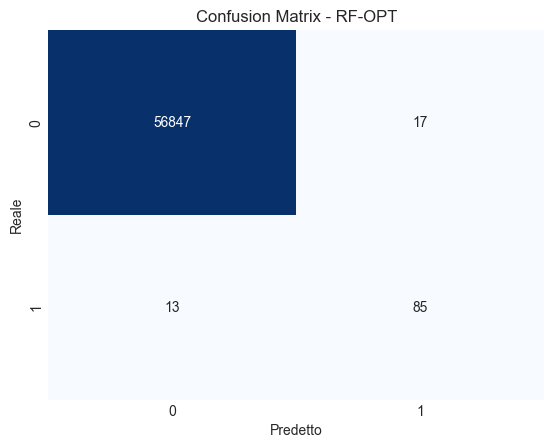


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.83      0.87      0.85        98

     accuracy                           1.00     56962
    macro avg       0.92      0.93      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Modello Random Forest Ottimizzato salvato.


In [ ]:
hyperparams_filename_rf = 'best_rf_hyperparams.json'
FORCE_NEW_SEARCH_RF = False
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

if not FORCE_NEW_SEARCH_RF and os.path.exists(hyperparams_filename_rf):
    print(f"Caricamento iperparametri per pipeline RF da '{hyperparams_filename_rf}'...")
    with open(hyperparams_filename_rf, 'r') as f:
        best_rf_params_loaded = json.load(f)
    print(f"Iperparametri caricati: {best_rf_params_loaded}")
    
    # Creazione pipeline con parametri caricati
    print(f"\n--- Addestramento Pipeline Random Forest con Iperparametri Caricati ---")
    rf_pipeline_tuned = ImbPipeline([
        ('feature_selection', SelectFromModel(
            RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced_subsample',
                n_jobs=-1
            ),
            threshold="median"
        )),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    rf_pipeline_tuned.set_params(**best_rf_params_loaded)
    rf_pipeline_tuned.fit(X_train, y_train)
    print("Pipeline Random Forest addestrata con iperparametri caricati.")
    
else:
    print(f"\nInizio Randomized Search per Pipeline RF...")
    
    # Definizione spazio parametri
    param_dist_rf_pipeline = {
        'feature_selection__estimator__n_estimators': [50, 100, 150],
        'classifier__n_estimators': randint(100, 301),
        'classifier__max_depth': [10, 20, 30, 40, None],
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__criterion': ['gini', 'entropy']
    }
    
    # Pipeline per tuning
    rf_pipeline_for_tuning = ImbPipeline([
        ('feature_selection', SelectFromModel(
            RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced_subsample',
                n_jobs=-1
            ),
            threshold="median"
        )),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # Randomized Search
    random_search_rf = RandomizedSearchCV(
        estimator=rf_pipeline_for_tuning,
        param_distributions=param_dist_rf_pipeline,
        n_iter=20,
        scoring='average_precision',
        cv=cv_stratified,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search_rf.fit(X_train, y_train)
    best_rf_params_found = random_search_rf.best_params_
    
    # Salvataggio parametri
    try:
        with open(hyperparams_filename_rf, 'w') as f:
            json.dump(best_rf_params_found, f, indent=4)
        print(f"Migliori iperparametri salvati in '{hyperparams_filename_rf}'")
    except Exception as e:
        print(f"Errore durante il salvataggio: {e}")
    
    rf_pipeline_tuned = random_search_rf.best_estimator_


y_pred_rf_tuned = rf_pipeline_tuned.predict(X_test)
y_pred_proba_rf_tuned = rf_pipeline_tuned.predict_proba(X_test)

selected_features_tuned = X_train.columns[rf_pipeline_tuned.named_steps['feature_selection'].get_support()].tolist()


results_rf_tuned = evaluate_model(
    y_test,
    y_pred_rf_tuned,
    y_pred_proba_rf_tuned,
    "RF-OPT",
    n_test_samples=len(y_test)
)
model_results.append(results_rf_tuned)

joblib.dump(ImbPipeline(rf_pipeline_tuned.steps[1:]), 'RF-OPT_model.joblib')
joblib.dump(selected_features_tuned, 'RF-OPT_columns.joblib')
print("Modello Random Forest Ottimizzato salvato.")

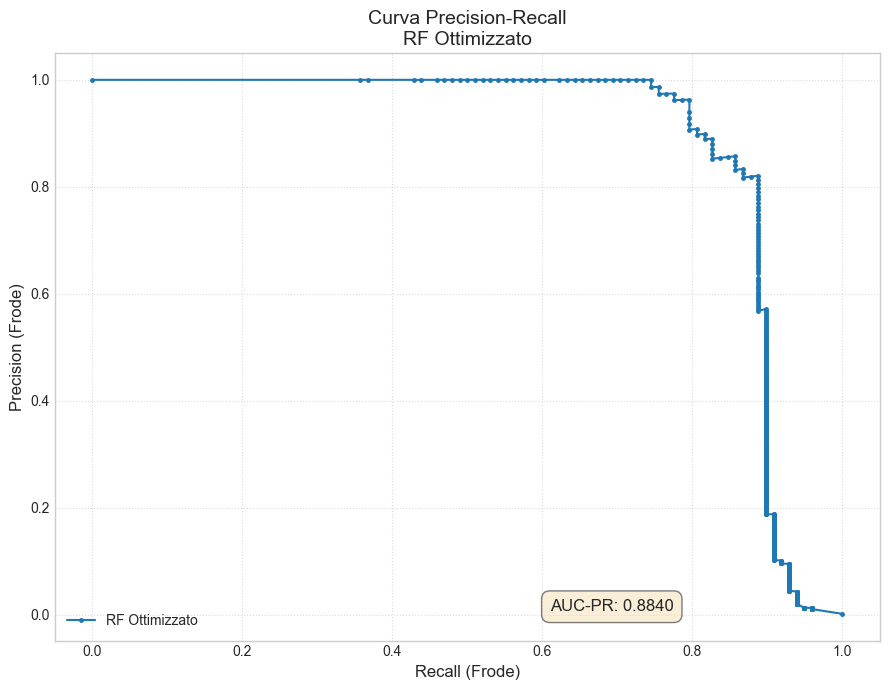


Soglia per RF Ottimizzato (Max F1-Score): 0.7670
  Con questa soglia -> F1-Score: 0.8715, Precision: 0.9630, Recall: 0.7959
Soglia ottimale per F1 (RF Ottimizzato: 0.7670) salvata in 'RF-OPT_thresh.json'

--- Valutazione RF Ottimizzato con Soglia Ottimizzata per Max F1 (0.7670) ---
--- Valutazione: RF Ottimizzato, ThMaxF1=0.7670 ---
Accuracy: 0.9996
  Intervallo di Confidenza (95%) per Accuracy: [0.9994 - 0.9997]
Precision (Fraud): 0.9630
Recall (Fraud):    0.7959
F1-Score (Fraud):  0.8715
  Calculating Bootstrap CIs (1000 iterations, 95% CI) for P, R, F1 (Fraud)...
    Bootstrap CI Precision (Fraud): [0.9166 - 1.0000]
    Bootstrap CI Recall (Fraud):    [0.7174 - 0.8726]
    Bootstrap CI F1-Score (Fraud):  [0.8169 - 0.9222]
ROC AUC Score: 0.9733
Average Precision (AUC-PR): 0.8840

Confusion Matrix:


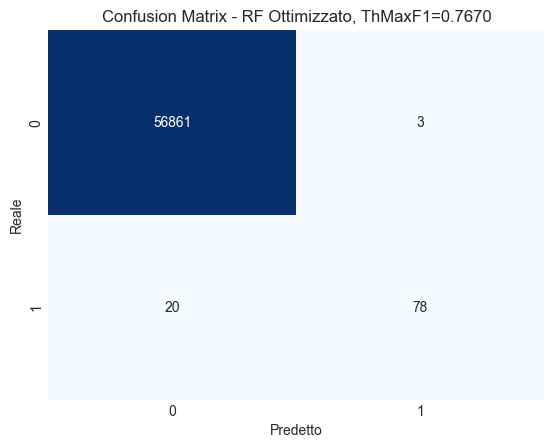


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.96      0.80      0.87        98

     accuracy                           1.00     56962
    macro avg       0.98      0.90      0.94     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------

Risultati per RF Ottimizzato, ThMaxF1=0.7670 aggiunti a model_results.


In [24]:
# Estrazione probabilità per la classe positiva (fraud)
y_pred_proba_fraud_rf_tuned = y_pred_proba_rf_tuned[:, 1]
model_name_rf_for_plot = "RF Ottimizzato"

# Plot della curva Precision-Recall
plot_precision_recall_curve(
    y_test,
    y_pred_proba_fraud_rf_tuned,
    model_name_rf_for_plot
)

# Ricerca soglia ottimale per massimizzare F1-score
optimal_threshold_rf_f1, f1_val_rf, prec_rf_at_f1, rec_rf_at_f1 = find_and_save_optimal_f1_threshold(
    y_test,
    y_pred_proba_fraud_rf_tuned,
    model_name_prefix="RF-OPT",
    model_description_for_print=model_name_rf_for_plot
)

# Applicazione soglia ottimizzata
y_pred_rf_optimized_threshold = (y_pred_proba_fraud_rf_tuned >= optimal_threshold_rf_f1).astype(int)
model_name_rf_optimized = f"{model_name_rf_for_plot}, ThMaxF1={optimal_threshold_rf_f1:.4f}"

print(f"\n--- Valutazione {model_name_rf_for_plot} con Soglia Ottimizzata per Max F1 ({optimal_threshold_rf_f1:.4f}) ---")

# Valutazione con soglia ottimizzata
results_rf_optimized_threshold = evaluate_model(
    y_test,
    y_pred_rf_optimized_threshold,
    y_pred_proba_rf_tuned,
    model_name_rf_optimized,
    n_test_samples=len(y_test)
)
model_results.append(results_rf_optimized_threshold)
print(f"Risultati per {model_name_rf_optimized} aggiunti a model_results.")
    

In [28]:
pd.DataFrame(model_results[4:6])

,model,accuracy,acc_ci_lower,acc_ci_upper,precision_fraud,precision_fraud_ci_lower,precision_fraud_ci_upper,recall_fraud,recall_fraud_ci_lower,recall_fraud_ci_upper,f1_fraud,f1_fraud_ci_lower,f1_fraud_ci_upper,roc_auc,auc_pr
0,Random Forest,0.999350,0.999105,0.999529,0.808081,0.733280,0.882369,0.816327,0.736239,0.894774,0.812183,0.747472,0.868300,0.958148,0.868955
1,RF-OPT,0.999473,0.999248,0.999631,0.833333,0.760858,0.900903,0.867347,0.795154,0.928597,0.850000,0.790954,0.896559,0.973337,0.883970


**Osservazioni sull'Ottimizzazione degli Iperparametri per Random Forest con `RandomizedSearchCV`**

Il processo di ottimizzazione degli iperparametri per il Random Forest Classifier è stato eseguito utilizzando `RandomizedSearchCV` e includendo SMOTE nella pipeline per la gestione dello sbilanciamento durante la validazione incrociata. La metrica target per l'ottimizzazione è stata l'AUC-PR (`average_precision`).

L'ottimizzazione degli iperparametri ha portato a un **miglioramento tangibile** nelle metriche chiave per la classe frode rispetto al modello Random Forest base.
-   Il **Recall per le frodi è aumentato**, indicando che il modello ottimizzato è in grado di identificare una porzione maggiore delle frodi effettive.
-   Anche la **Precision per le frodi è leggermente migliorata**.
-   Di conseguenza, l'**F1-Score è aumentato**, mostrando un miglior bilanciamento complessivo.
-   L'**AUC-PR, la metrica guida dell'ottimizzazione, è anch'essa migliorata**, confermando che la ricerca ha trovato una configurazione di iperparametri più performante.

## 8. Confronto Finale dei Modelli e Conclusioni

Ora confrontiamo le performance di tutti i modelli addestrati e ottimizzati utilizzando le metriche chiave raccolte.

In [25]:
pd.DataFrame(model_results)

,model,accuracy,acc_ci_lower,acc_ci_upper,precision_fraud,precision_fraud_ci_lower,precision_fraud_ci_upper,recall_fraud,recall_fraud_ci_lower,recall_fraud_ci_upper,f1_fraud,f1_fraud_ci_lower,f1_fraud_ci_upper,roc_auc,auc_pr
0,"LogReg Pipeline (k=10, C=0.0037)",0.975984,0.974694,0.977210,0.062069,0.049446,0.075576,0.918367,0.868095,0.968094,0.116279,0.094558,0.138763,0.976242,0.769683
1,"LogReg Pipeline (k=10, C=0.0037), ThMaxF1=0.9990",0.999298,0.999044,0.999484,0.802083,0.719969,0.879131,0.785714,0.705251,0.861711,0.793814,0.728447,0.854369,0.976242,0.769683
2,XGBoost,0.998666,0.998331,0.998934,0.576389,0.490994,0.658570,0.846939,0.771699,0.913598,0.685950,0.624377,0.749139,0.967874,0.848132
3,"XGBoost, ThMaxF1={optimal_threshold_xgb_f1:.4f}",0.999596,0.999394,0.999731,0.941176,0.886055,0.987809,0.816327,0.731183,0.886817,0.874317,0.819662,0.919273,0.967874,0.848132
4,Random Forest,0.999350,0.999105,0.999529,0.808081,0.733280,0.882369,0.816327,0.736239,0.894774,0.812183,0.747472,0.868300,0.958148,0.868955
5,RF-OPT,0.999473,0.999248,0.999631,0.833333,0.760858,0.900903,0.867347,0.795154,0.928597,0.850000,0.790954,0.896559,0.973337,0.883970
6,"RF Ottimizzato, ThMaxF1=0.7670",0.999596,0.999394,0.999731,0.962963,0.916616,1.000000,0.795918,0.717391,0.872610,0.871508,0.816893,0.922179,0.973337,0.883970


### 8.1. Confronto Statistico con il Test di McNemar

Dopo aver analizzato le metriche di performance aggregate, è utile condurre un test statistico per determinare se le differenze osservate nelle capacità di classificazione dei nostri modelli finalisti sono statisticamente significative. Per questo scopo, utilizzeremo il **Test di McNemar**.

**Cos'è il Test di McNemar?**
Il Test di McNemar è un test statistico non parametrico utilizzato su dati nominali appaiati. È particolarmente adatto per confrontare le performance di due modelli di classificazione sullo stesso dataset di test. Il test si concentra sui casi in cui le predizioni dei due modelli differiscono.

**Ipotesi del Test:**
* **Ipotesi Nulla (H0)**: I due modelli hanno la stessa proporzione di errore (cioè, non c'è una differenza significativa nella loro performance predittiva sui casi discordanti). Questo è anche noto come ipotesi di omogeneità marginale.
* **Ipotesi Alternativa (H1)**: I due modelli hanno proporzioni di errore differenti (cioè, uno dei modelli commette significativamente meno errori dell'altro sui casi discordanti).

**Perché utilizzarlo?**
Mentre metriche come l'F1-score o l'AUC-PR ci danno una misura quantitativa della performance, non ci dicono se la differenza tra due modelli sia dovuta al caso o se sia statisticamente robusta. Il Test di McNemar ci aiuta a rispondere a questa domanda, focalizzandosi sui disaccordi tra i modelli.

**Modelli Selezionati per il Confronto:**
Sulla base delle performance osservate, confronteremo a coppie i seguenti modelli, utilizzando le loro predizioni generate con le rispettive soglie di classificazione ottimizzate:
1.  Regressione Logistica con penalizzazione L1
2.  XGBoost 
3.  Random Forest Ottimizzato 

Procederemo con il calcolo del test per ciascuna coppia. Un p-value inferiore al nostro livello di significatività (tipicamente $\alpha = 0.05$) ci porterà a rigettare l'ipotesi nulla, indicando una differenza statisticamente significativa tra i due modelli confrontati.

In [26]:
model_predictions_mcnemar = {}
y_true_for_mcnemar = y_test

#Drop "RF"
models_for_mcnemar = model_prefixes.copy()
models_for_mcnemar.remove("RF")

for prefix in models_for_mcnemar:
    model_key_name = prefix_to_model_key_map.get(prefix, prefix) 
    model = joblib.load(f'{prefix}_model.joblib')
    cols_to_select = joblib.load(f'{prefix}_columns.joblib')
    with open(f'{prefix}_thresh.json', 'r') as f:
        threshold = json.load(f)['thresh'] 

    X_test_filtered_for_model = X_test[cols_to_select]

    probabilities = model.predict_proba(X_test_filtered_for_model)[:, 1]
    predictions_for_mcnemar = (probabilities >= threshold).astype(int)
    model_predictions_mcnemar[model_key_name] = predictions_for_mcnemar


print(f"\nUtilizzo di y_test con {len(y_true_for_mcnemar)} campioni.")
print(f"Nomi dei modelli processati e inclusi nelle predizioni: {list(model_predictions_mcnemar.keys())}")
print(f"Numero di set di predizioni raccolti: {len(model_predictions_mcnemar)}")
print(f"Numero di etichette vere (y_true_for_mcnemar): {len(y_true_for_mcnemar)}")



/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/home/siralex/Desktop/CREDIT_CARD/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Utilizzo di y_test con 56962 campioni.
Nomi dei modelli processati e inclusi nelle predizioni: ['LogReg', 'XGBoost', 'RandomForest + GridSearchCV']
Numero di set di predizioni raccolti: 3
Numero di etichette vere (y_true_for_mcnemar): 56962


In [ ]:

model_names_mcnemar = list(model_predictions_mcnemar.keys())
results_list = [] 

print(f"\n--- Esecuzione Test di McNemar (alpha=0.05) ---")
print("Confronto tra coppie di modelli:")
print("H0: I due modelli hanno la stessa proporzione di errore.")
print("H1: I due modelli hanno proporzioni di errore differenti.\n")

for model1_name, model2_name in combinations(model_names_mcnemar, 2):
    print(f"Confronto in corso: {model1_name} vs {model2_name}")

    m1_preds = model_predictions_mcnemar[model1_name]
    m2_preds = model_predictions_mcnemar[model2_name]

    # Costruzione della tabella di contingenza per McNemar
    # a: Modello 1 corretto, Modello 2 corretto
    # b: Modello 1 corretto, Modello 2 errato
    # c: Modello 1 errato, Modello 2 corretto
    # d: Modello 1 errato, Modello 2 errato
    
    a = np.sum((m1_preds == y_true_for_mcnemar) & (m2_preds == y_true_for_mcnemar))
    b = np.sum((m1_preds == y_true_for_mcnemar) & (m2_preds != y_true_for_mcnemar)) # M1 ok, M2 err
    c = np.sum((m1_preds != y_true_for_mcnemar) & (m2_preds == y_true_for_mcnemar)) # M1 err, M2 ok
    d = np.sum((m1_preds != y_true_for_mcnemar) & (m2_preds != y_true_for_mcnemar))
    
    mcnemar_contingency_table_statsmodels = [[a, b], [c, d]] 
    
    current_result = {
        'Modello 1': model1_name,
        'Modello 2': model2_name,
        'M1_cor_M2_err (b)': b,
        'M1_err_M2_cor (c)': c,
        'Statistica Test': None,
        'p-value': None,
        'Conclusione (alpha=0.05)': '',
        'Dettaglio Performance': ''
    }

    if b == 0 and c == 0:
        conclusion = "Equivalenti (stesse predizioni errate/corrette)"
        current_result['Conclusione (alpha=0.05)'] = conclusion
        current_result['Statistica Test'] = 0
        current_result['p-value'] = 1.0
        print(f"  I due modelli hanno esattamente le stesse predizioni (nessun disaccordo). Sono equivalenti.")
        results_list.append(current_result)
        print("----------------------------------------------------------\n")
        continue

    # Se b+c < 30, è meglio usare exact=True (test binomiale esatto)
    use_exact_mcnemar = (b + c) < 30
    
    try:
        result_mcnemar = mcnemar(mcnemar_contingency_table_statsmodels, exact=use_exact_mcnemar, correction=True)
        
        current_result['Statistica Test'] = f"{result_mcnemar.statistic:.4f}"
        current_result['p-value'] = f"{result_mcnemar.pvalue:.4f}"
        
        alpha = 0.05
        if result_mcnemar.pvalue < alpha:
            conclusion = f"H0 Rigettata (p < {alpha})"
            current_result['Conclusione (alpha=0.05)'] = conclusion
            if b > c:
                performance_detail = f"{model1_name} significativamente migliore ({b} vs {c} errori a suo favore)"
            elif c > b:
                performance_detail = f"{model2_name} significativamente migliore ({c} vs {b} errori a suo favore)"
            else:
                performance_detail = "Disaccordi uguali, ma differenza significativa (raro)"
            current_result['Dettaglio Performance'] = performance_detail
            print(f"  Conclusione: {conclusion}. {performance_detail}")
        else:
            conclusion = f"H0 Non Rigettata (p >= {alpha})"
            current_result['Conclusione (alpha=0.05)'] = conclusion
            current_result['Dettaglio Performance'] = "Nessuna differenza significativa nelle proporzioni di errore."
            print(f"  Conclusione: {conclusion}. Nessuna differenza significativa.")

    except ValueError as e:
        error_msg = f"Errore McNemar: {e}"
        print(f"  {error_msg}")
        print(f"  Disaccordi: b = {b}, c = {c}")
        current_result['Conclusione (alpha=0.05)'] = "Errore nel test"
        current_result['Dettaglio Performance'] = error_msg
    
    results_list.append(current_result)
    print("----------------------------------------------------------\n")

pd.DataFrame(results_list)


--- Esecuzione Test di McNemar (alpha=0.05) ---
Confronto tra coppie di modelli:
H0: I due modelli hanno la stessa proporzione di errore.
H1: I due modelli hanno proporzioni di errore differenti.

Confronto in corso: LogReg vs XGBoost
  Conclusione: H0 Rigettata (p < 0.05). XGBoost significativamente migliore (22 vs 5 errori a suo favore)
----------------------------------------------------------

Confronto in corso: LogReg vs RandomForest + GridSearchCV
  Conclusione: H0 Rigettata (p < 0.05). RandomForest + GridSearchCV significativamente migliore (20 vs 3 errori a suo favore)
----------------------------------------------------------

Confronto in corso: XGBoost vs RandomForest + GridSearchCV
  Conclusione: H0 Non Rigettata (p >= 0.05). Nessuna differenza significativa.
----------------------------------------------------------



,Modello 1,Modello 2,M1_cor_M2_err (b),M1_err_M2_cor (c),Statistica Test,p-value,Conclusione (alpha=0.05),Dettaglio Performance
0,LogReg,XGBoost,5,22,9.4815,0.0021,H0 Rigettata (p < 0.05),XGBoost significativamente migliore (22 vs 5 errori a suo favore)
1,LogReg,RandomForest + GridSearchCV,3,20,3.0000,0.0005,H0 Rigettata (p < 0.05),RandomForest + GridSearchCV significativamente migliore (20 vs 3 errori a suo favore)
2,XGBoost,RandomForest + GridSearchCV,5,5,5.0000,1.0000,H0 Non Rigettata (p >= 0.05),Nessuna differenza significativa nelle proporzioni di errore.


### Interpretazione dei Risultati del Test di McNemar e Conclusioni

1.  Sia XGBoost che Random Forest Ottimizzato mostrano una superiorità statisticamente significativa rispetto a LogReg in termini di pattern di errore.
2.  Il confronto tra XGBoost e Random Forest Ottimizato non ha rivelato una differenza statisticamente significativa nei loro pattern di errore (p=1.0000). Questo suggerisce che, sebbene le loro metriche aggregate (come F1-score e AUC-PR) possano differire leggermente (con RF Ottimizzato che tendeva ad avere valori migliori), i loro errori specifici sui casi di disaccordo non sono fondamentalmente diversi dal punto di vista statistico.

**Implicazioni per la Scelta del Modello Finale:**

Il modello di regressione logistica nonostante le buone metriche F1 dopo il tuning della soglia, sembra essere statisticamente meno performante di XGBoost e Random Forest Ottimizzato in termini di pattern di errore.
* La scelta tra Random Forest Ottimizzato e XGBoost è meno netta secondo il Test di McNemar sui pattern di errore.
* Il Random Forest Ottimizzato aveva metriche F1-score e AUC-PR aggregate leggermente superiori a XGBoost Base.
* Il Test di McNemar indica che la loro "qualità" degli errori (sui casi discordanti) è statisticamente simile.
* In questo scenario, la decisione potrebbe basarsi su:
* La leggera preferenza per le metriche F1/AUC-PR del Random Forest Ottimizzato.
* Considerazioni sulla complessità del modello (XGBoost e Random Forest sono entrambi modelli ad ensemble).